# Домашнее задание 2

### 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

**Добавим библиотеки**

In [1]:
import numpy as np
import pandas as pd
import itertools
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, TfidfModel

import pymorphy2
from nltk.corpus import stopwords
from razdel import tokenize


%matplotlib inline

In [2]:
# import nltk
# nltk.download()

**Функции**

In [3]:
def clean_text(text):
    '''
    Очистка текста
    '''
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    return text


def lemmatization(text):
    '''
    Лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова
    '''
    # [0]
    if not isinstance(text, str):
        text = str(text)
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    return words_lem_without_stopwords

In [4]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [5]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Построение модели**

Загружаем новости

In [7]:
# xyz = pd.read_csv("articles_idf.csv")
# xyz.head(3)

In [8]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [9]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Загрузим разметку

In [10]:
churn = pd.read_csv("users_churn.csv")
churn.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [11]:
stopword_ru = stopwords.words('russian')
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

Чистим текст и делаем лематизацию

In [12]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

cache = {}
morph = pymorphy2.MorphAnalyzer()
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

C:\Users\leva_\AppData\Local\Temp\ipykernel_12024\826858971.py:10: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: total: 1min 41s
Wall time: 1min 48s


Обучаем модель

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = news['title'].tolist()
# Create a corpus from a list of texts
common_dictionary = Dictionary(news['title'].values)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Обучаем модель по LDA

In [14]:
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Получаем векторное представление новостей

In [15]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

Функция для получения эмбеддингов пользователей и последующего обучения модели.

In [16]:
def train_embeddings_and_model(users, churn, user_embedding_fnc):
    # Получаем эмбеддинги пользователей по темам.
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(user_embedding_fnc, 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

    # Обучаем логистическую регрессию на данных оттока и эмбеддингах пользователей.
    X = pd.merge(user_embeddings, churn, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'],
                                                        random_state=0)
    # logreg = LogisticRegression()
    logreg = RandomForestClassifier()
    logreg.fit(X_train, y_train)

    # Рассчитаем F1-score, ROC-AUC, построим матрицу ошибок
    preds = logreg.predict_proba(X_test)[:, 1]
    # print(pd.DataFrame({'test': y_test, 'pred': preds}))
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    # print(precision, recall)
    f1 = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(f1)

    precision_score = precision[ix]
    recall_score = recall[ix]
    f1_score = f1[ix]
    print(f'F1 score: {f1_score}')

    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC-AUC score: {roc_auc}')

    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix,
                          classes=['Non-Churn', 'Churn'],
                          title='Confusion matrix')
    plt.show()

    return {'precision': precision_score,
            'recall': recall_score,
            'f1_score': f1_score,
            'roc_auc': roc_auc}

Находим эмбеддинги и обучаем модель, сохраняем метрики.

F1 score: 0.8176100628930818
ROC-AUC score: 0.9715843944415373


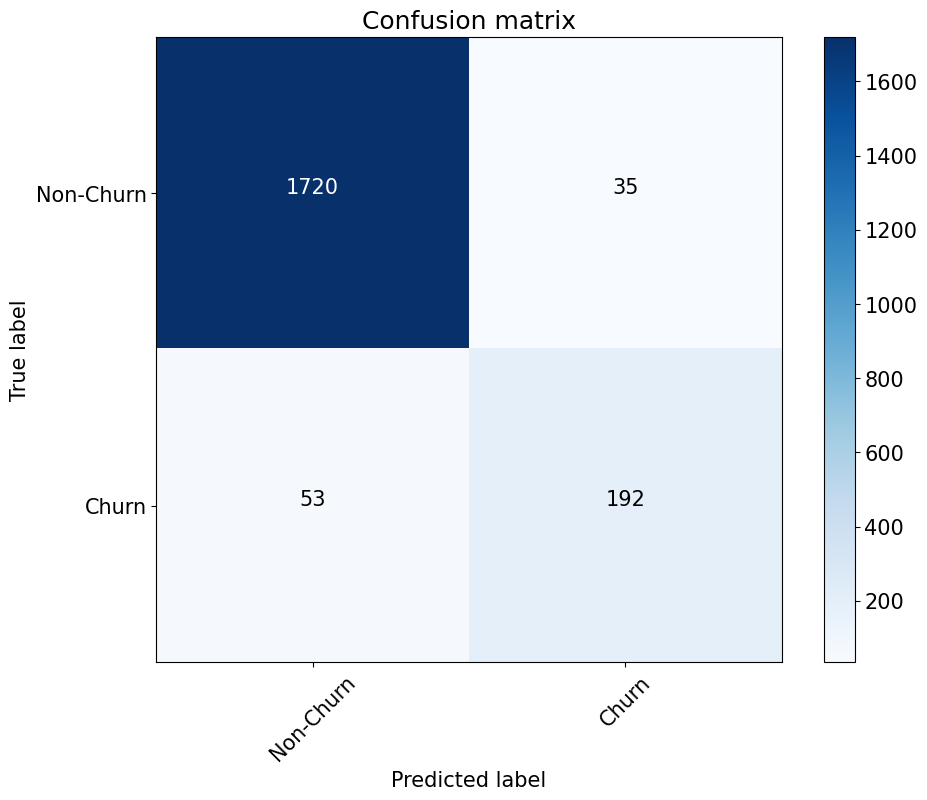

In [17]:
metrics_mean = train_embeddings_and_model(users, churn, get_user_embedding)
metrics_df = pd.DataFrame({key: [value] for key, value in metrics_mean.items()})

In [18]:
metrics_df

,precision,recall,f1_score,roc_auc
0,0.840517,0.795918,0.81761,0.971584


Меняем .mean() на .median().

In [19]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # .mean() на .median()
    user_vector = np.median(user_vector, 0)
    return user_vector

Сохраняем метрики для user embeddings через .median().

F1 score: 0.9539748953974895
ROC-AUC score: 0.9973393801965231


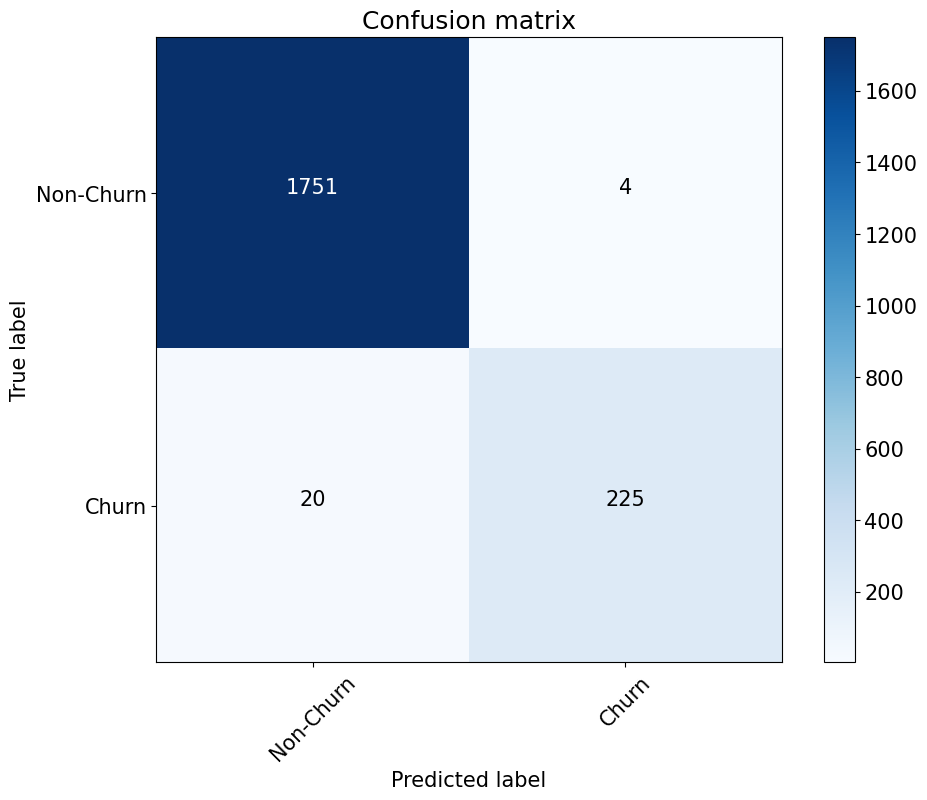

C:\Users\leva_\AppData\Local\Temp\ipykernel_12024\805220735.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_median, ignore_index=True)


In [20]:
metrics_median = train_embeddings_and_model(users, churn, get_user_embedding_median)
metrics_df = metrics_df.append(metrics_median, ignore_index=True)

In [21]:
metrics_df

,precision,recall,f1_score,roc_auc
0,0.840517,0.795918,0.817610,0.971584
1,0.978541,0.930612,0.953975,0.997339


### Задание 3
Повторить п.2, но используя уже не медиану, а max.

Меняем .mean() на .max().

In [22]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # .mean() на .max()
    user_vector = np.max(user_vector, 0)
    return user_vector

Сохраняем метрики для user embeddings через .max().

F1 score: 0.8434237995824634
ROC-AUC score: 0.9821082621082621


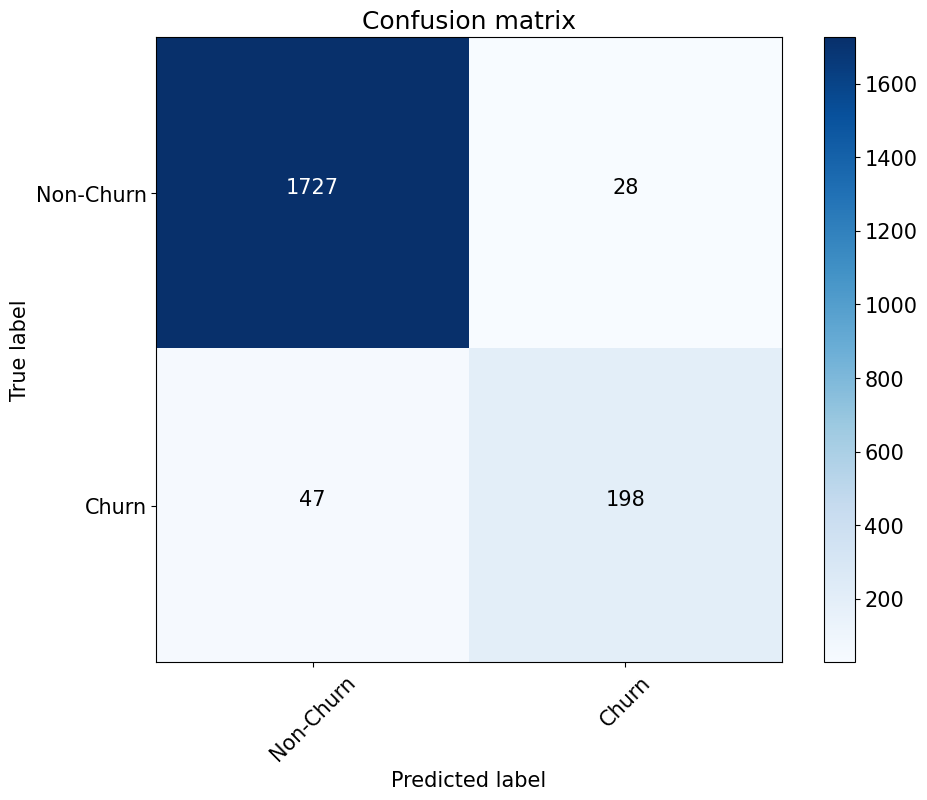

C:\Users\leva_\AppData\Local\Temp\ipykernel_12024\3498474660.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_max, ignore_index=True)


In [23]:
metrics_max = train_embeddings_and_model(users, churn, get_user_embedding_max)
metrics_df = metrics_df.append(metrics_max, ignore_index=True)

In [24]:
metrics_df

,precision,recall,f1_score,roc_auc
0,0.840517,0.795918,0.817610,0.971584
1,0.978541,0.930612,0.953975,0.997339
2,0.863248,0.824490,0.843424,0.982108


### Задание 4*
Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf 
Подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал. 
Подсказка 2: нужен именно idf, как вес.

Считаем tf-idf значения для каждого слова в каждом документе.

In [25]:
tfidf_model = TfidfModel(common_corpus)
common_corpus_tfidf = [tfidf_model[doc] for doc in common_corpus]

Тренируем LDA на tf-idf корпусе.

In [26]:
lda_tfidf = LdaModel(common_corpus_tfidf, num_topics=25, id2word=common_dictionary)#, passes=10)

Получаем эмбеддинги документов по темам, с учетом подсчета для нового документа значений tf-idf.

In [27]:
def get_lda_vector_tfidf(text):
    unseen_doc = tfidf_model[common_dictionary.doc2bow(text)]
    lda_tuple = lda_tfidf[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [28]:
topic_matrix_tfidf = pd.DataFrame([get_lda_vector_tfidf(text) for text in news['title'].values])
topic_matrix_tfidf.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix_tfidf['doc_id'] = news['doc_id'].values
topic_matrix_tfidf = topic_matrix_tfidf[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
doc_dict = dict(zip(topic_matrix_tfidf['doc_id'].values, topic_matrix_tfidf[['topic_{}'.format(i) for i in range(25)]].values))

F1 score: 0.7924528301886793
ROC-AUC score: 0.9727437641723355


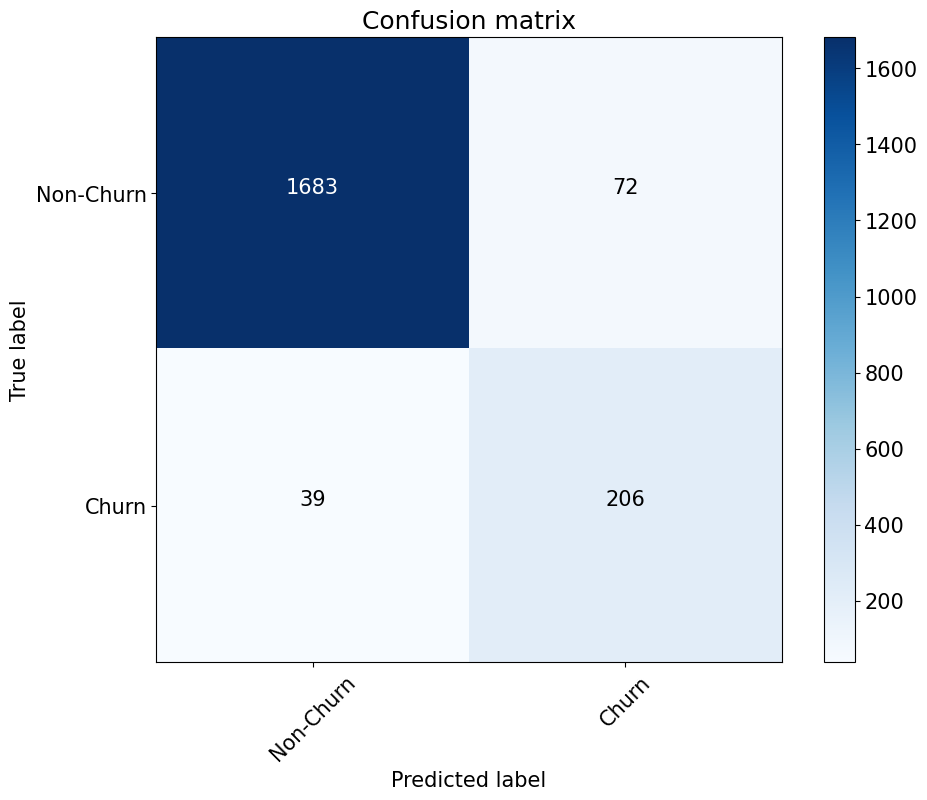

C:\Users\leva_\AppData\Local\Temp\ipykernel_12024\1970438911.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_tfidf, ignore_index=True)


In [29]:
metrics_tfidf = train_embeddings_and_model(users, churn, get_user_embedding)
metrics_df = metrics_df.append(metrics_tfidf, ignore_index=True)

### 5. Сформировать на выходе единую таблицу, сравнивающую качество разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score. 

In [30]:
metrics_df.index = ['mean', 'median', 'max', 'idf_mean']

In [31]:
metrics_df

,precision,recall,f1_score,roc_auc
mean,0.840517,0.795918,0.817610,0.971584
median,0.978541,0.930612,0.953975,0.997339
max,0.863248,0.824490,0.843424,0.982108
idf_mean,0.736842,0.857143,0.792453,0.972744


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.

Видим, что получение эмбендингов пользователей по медиане лучше, чем по максимальному значению или среднему, при этом между собой они практически одинаково показали результат.

Модель получения эмбендингов по медиане работает лучше потому, что более устойчива к выбросам. 

Среднее по tf-idf сработало еще хуже значений среднего и максимального.

Найдем user embeddings по tf-idf, но с помощью медианы и максимального значения.

F1 score: 0.84765625
ROC-AUC score: 0.9831048316762603


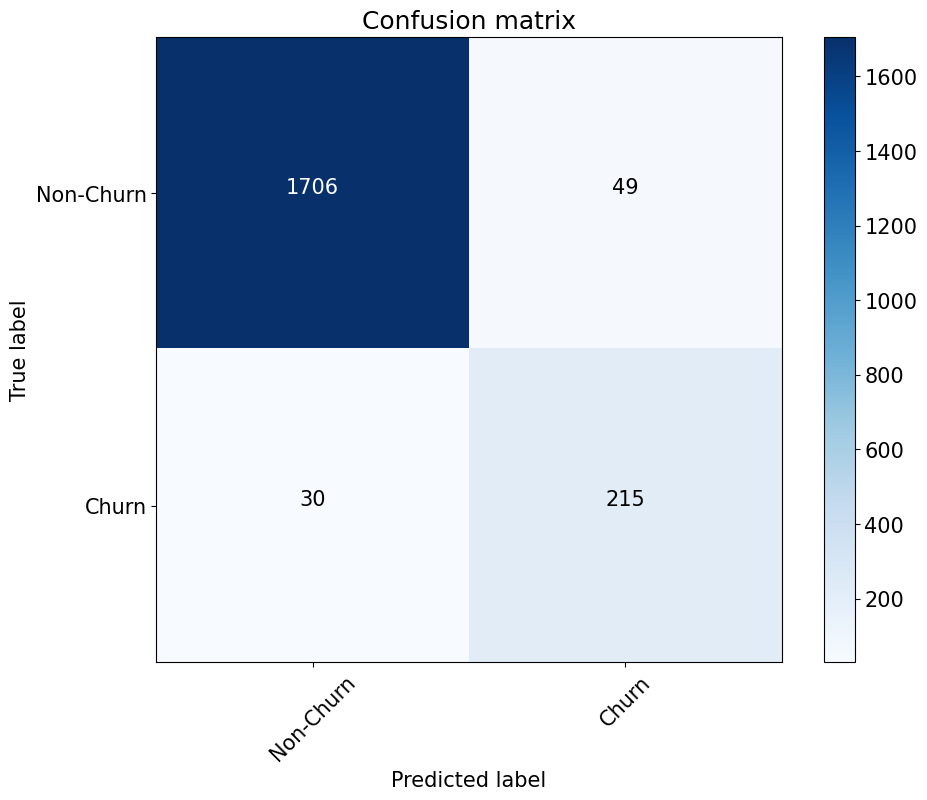

C:\Users\leva_\AppData\Local\Temp\ipykernel_12024\4175648366.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_tfidf_median, ignore_index=True)


In [32]:
metrics_tfidf_median = train_embeddings_and_model(users, churn, get_user_embedding_median)
metrics_df = metrics_df.append(metrics_tfidf_median, ignore_index=True)

F1 score: 0.7108167770419426
ROC-AUC score: 0.9346275946275947


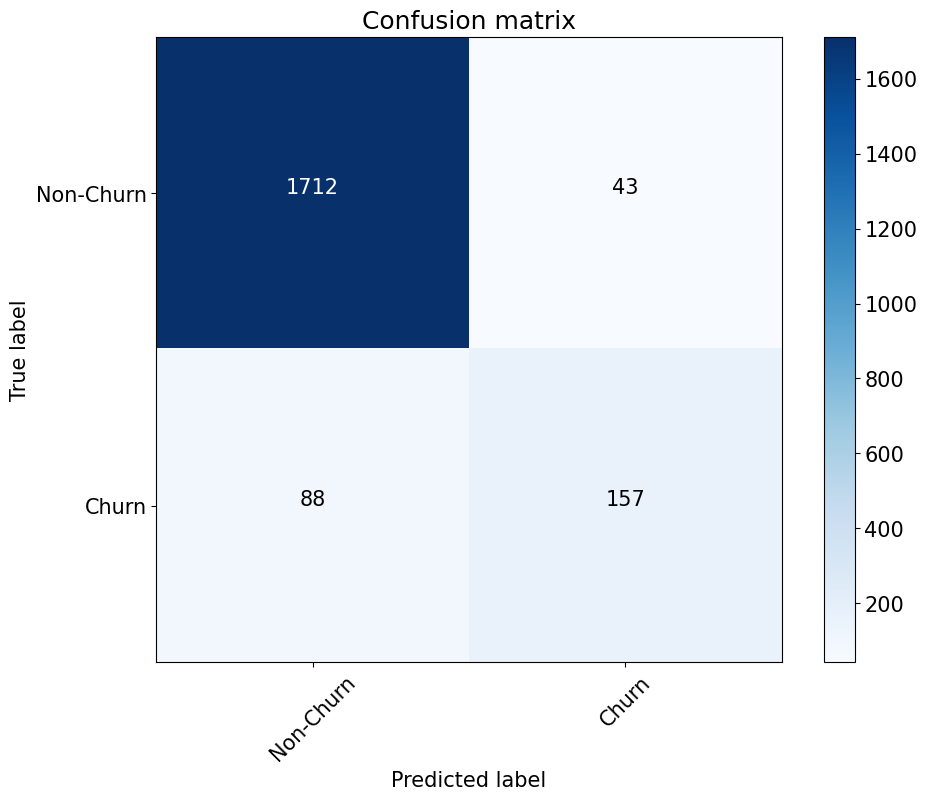

C:\Users\leva_\AppData\Local\Temp\ipykernel_12024\1956940025.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics_tfidf_max, ignore_index=True)


In [33]:
metrics_tfidf_max = train_embeddings_and_model(users, churn, get_user_embedding_max)
metrics_df = metrics_df.append(metrics_tfidf_max, ignore_index=True)

In [34]:
metrics_df.index = ['mean', 'median', 'max', 'idf_mean', 'idf_median', 'idf_max']

In [35]:
metrics_df

,precision,recall,f1_score,roc_auc
mean,0.840517,0.795918,0.817610,0.971584
median,0.978541,0.930612,0.953975,0.997339
max,0.863248,0.824490,0.843424,0.982108
idf_mean,0.736842,0.857143,0.792453,0.972744
idf_median,0.812734,0.885714,0.847656,0.983105
idf_max,0.774038,0.657143,0.710817,0.934628


Лучшим все так же остался метод нахождения при помощи медианы.